In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sqlite3
%matplotlib inline
from astropy import units as u
from astropy.coordinates import SkyCoord

import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.maps as maps
import lsst.sims.maf.metricBundles as mb

In [2]:
# 
conn = sqlite3.connect('avoid_geov1.6_10yrs.db')
sql = 'select altitude, azimuth, fieldRA, fieldDec, note from summaryallprops;'
obs = pd.read_sql(sql, conn)

# I think we need az to go +-180? 
alt = obs['altitude'].values
az = obs['azimuth'].values
az[np.where(az > 180)] = az[np.where(az > 180)] - 360

ra = obs['fieldRA'].values
dec = obs['fieldDec'].values

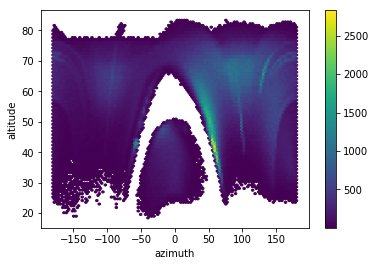

In [3]:
plt.hexbin(az, alt,  mincnt=.1)
plt.xlabel('azimuth')
plt.ylabel('altitude')
plt.colorbar()

In [4]:
val = np.abs(60. - 30.*(np.abs(az)/60.)**2-alt)
in_geo = np.where(val < 10.)[0]

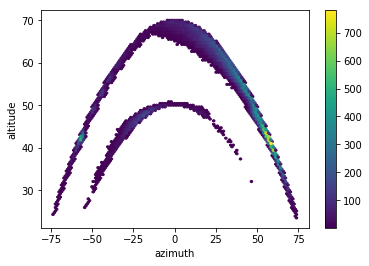

In [5]:
plt.hexbin(az[in_geo], alt[in_geo], mincnt=.1)
plt.xlabel('azimuth')
plt.ylabel('altitude')
plt.colorbar()

In [6]:
np.unique(obs['note'].values[in_geo])

array(['blob, gr, a', 'blob, gr, b', 'blob, iz, a', 'blob, iz, b',
       'blob, ri, a', 'blob, ri, b', 'blob, ug, a', 'blob, ug, b',
       'blob, ur, a', 'blob, ur, b', 'blob, yy, a', 'blob, yy, b',
       'blob, zy, a', 'blob, zy, b', 'greedy'], dtype=object)

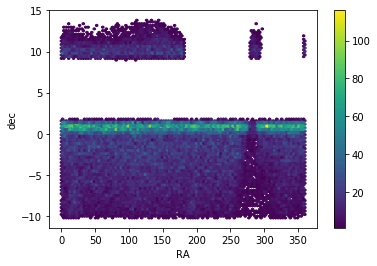

In [7]:
plt.hexbin(ra[in_geo], dec[in_geo], mincnt=.1)
plt.xlabel('RA')
plt.ylabel('dec')
plt.colorbar()

In [8]:
# Let's make some other coordinates
c = SkyCoord(ra=obs['fieldRA'].values*u.degree, dec=obs['fieldDec'].values*u.degree)
gal = c.galactic
eclip = c.barycentricmeanecliptic

In [9]:
in_low_eclip = np.where(np.abs(eclip.lat) < 10.*u.degree)[0]
in_low_gal = np.where(np.abs(gal.b) < 10.*u.degree)[0]

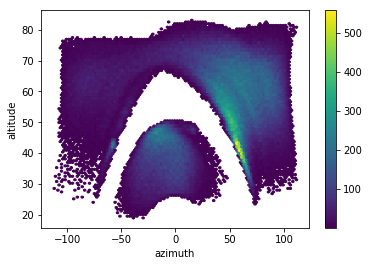

In [10]:
plt.hexbin(az[in_low_eclip], alt[in_low_eclip], mincnt=.1)
plt.xlabel('azimuth')
plt.ylabel('altitude')
plt.colorbar()

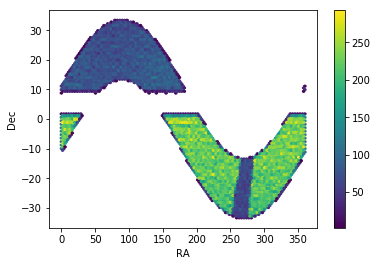

In [11]:
plt.hexbin(ra[in_low_eclip], dec[in_low_eclip], mincnt=.1)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()

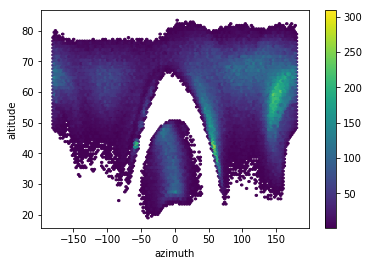

In [12]:
plt.hexbin(az[in_low_gal], alt[in_low_gal], mincnt=.1)
plt.xlabel('azimuth')
plt.ylabel('altitude')
plt.colorbar()

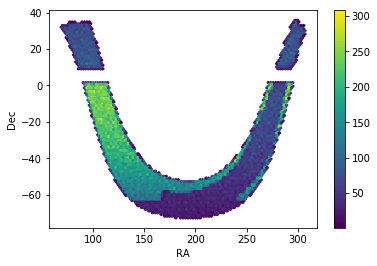

In [13]:
plt.hexbin(ra[in_low_gal], dec[in_low_gal], mincnt=.1)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()

In [14]:
print('Total number of observations=%i' % alt.size)
print('Total in GEO zone =%i' % in_geo.size)
print('Total in low eciptic= %i' % in_low_eclip.size)
print('Total in low galactic lat = %i' % in_low_gal.size)

Total number of observations=2213081
Total in GEO zone =107680
Total in low eciptic= 480549
Total in low galactic lat = 302827


In [15]:
print('Fraction in GEO region = %.3f' % (in_geo.size/alt.size))
print('Fraction in GEO and low ecliptic lat = %.3f' % (np.intersect1d(in_geo, in_low_eclip).size/alt.size))
print('Fraction in GEO and low galactic lat = %.3f' % (np.intersect1d(in_geo, in_low_gal).size/alt.size))


Fraction in GEO region = 0.049
Fraction in GEO and low ecliptic lat = 0.016
Fraction in GEO and low galactic lat = 0.005


In [16]:
# Let's just drop some MAF plots in here
dbFile = 'avoid_geov1.6_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [17]:
bundleList = []
sql = ''
metric = metrics.CountMetric(col='night')
slicer = slicers.HealpixSlicer()
plotDict = {}
bundleList.append(mb.MetricBundle(metric,slicer,sql, plotDict=plotDict))


metric = metrics.MedianMetric(col='airmass')
slicer = slicers.HealpixSlicer()
plotDict = {}
bundleList.append(mb.MetricBundle(metric,slicer,sql, plotDict=plotDict))



sql = 'filter="r"'
metric = metrics.Coaddm5Metric()
bundleList.append(mb.MetricBundle(metric,slicer,sql, plotDict=plotDict))


sql = ''
slicer = slicers.HealpixSlicer(latCol='altitude', lonCol='azimuth', latLonDeg=True, useCache=False)
metric = metrics.CountMetric('night', metricName='Nvisits as function of Alt/Az')
plotFuncs = [plots.LambertSkyMap()]

plotDict = {}
bundleList.append(mb.MetricBundle(metric, slicer, sql, plotFuncs=plotFuncs,
                                    plotDict=plotDict))



Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database SummaryAllProps with no constraint for columns ['airmass', 'night', 'fieldRA', 'fieldDec', 'altitude', 'azimuth'].
Found 2213081 visits
Running:  ['opsim_Count_night_HEAL', 'opsim_Median_airmass_HEAL']
Completed metric generation.
Running:  ['opsim_Nvisits_as_function_of_Alt_Az_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="r" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 480154 visits
Running:  ['opsim_CoaddM5_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 786 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 709.113  dipole: lon: 37.2363, lat: -80.9919, amp: 324.926
monopole: 1.36353  dipole: lon: 53.9433, lat: 85.8984, amp: 0.298669
Plotting complete.
Plotting figures with "filter="r"" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 231 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 26.4581  dipole: lon: 113.774, lat: -75.2493, amp: 0.577255
Plotting complete.


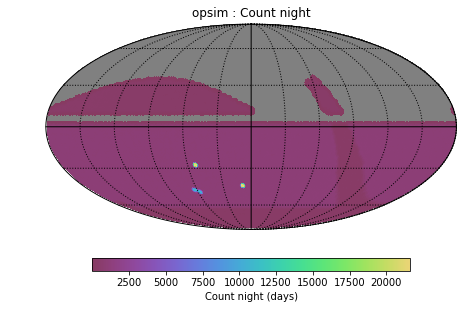

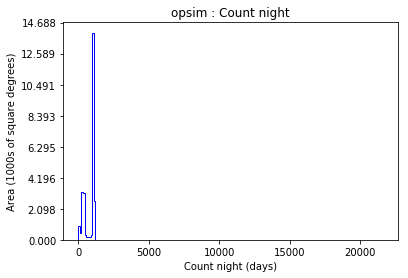

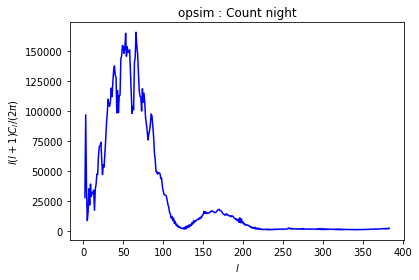

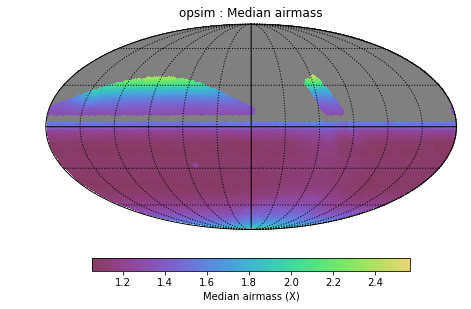

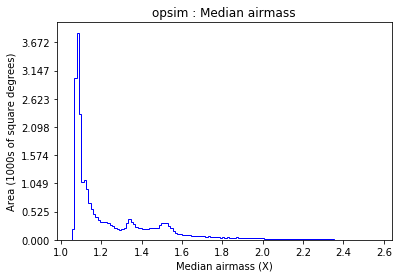

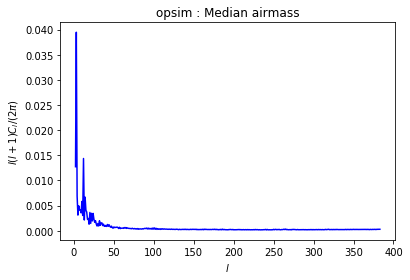

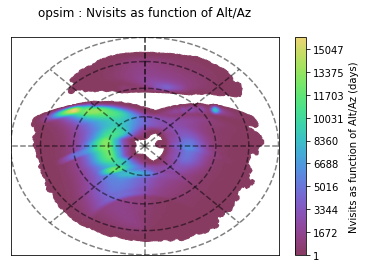

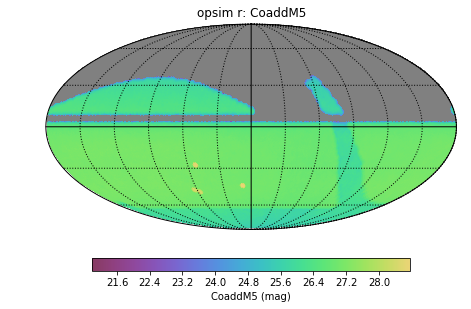

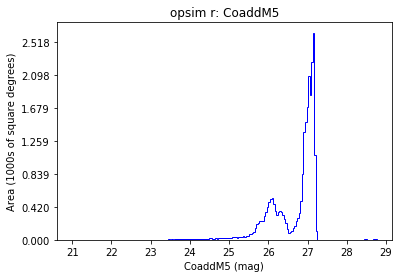

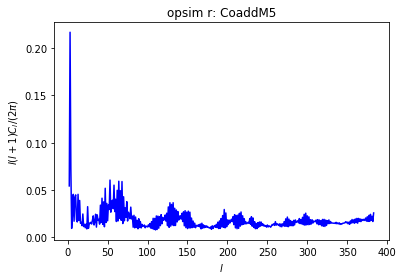

In [18]:
bg = mb.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

bg.plotAll(closefigs=False)